# Item-Based Recommendation System

In the item-based K nearest neighbours (KNN) model, we predict the rating of user **u** on movie **m** by looking at the top K movies that are similar to **m**, and produce a prediction by calculating the weighted average of ratings from user **u** on these movies.  
  
For building a similarity matrix of each pair of movie X and movie Y, the *Pearson correlation* is used. Built-in scikit-learn function is used for computing this similarty matrix.  
  
Afterwards, we predict the value of ratings user **u** gives to movie **m** as a weighted average of similar movies user **u** has rated.

### Load dependencies

In [1]:
# load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import requests
from imdbpie import Imdb
from sklearn.metrics import pairwise_distances,mean_squared_error,mean_absolute_error
from IPython.display import Image
from IPython.display import display
from numpy import nan

### Load data

In [2]:
data_dir = '../data/'

# users file
user_columns = ['user_id', 'age', 'sex', 'zip_code']
users = pd.read_csv(data_dir + 'Person.txt', sep='\t', names=user_columns, encoding='latin-1')

# ratings file
vote_columns = ['user_id', 'movie_id', 'rating1', 'rating2', 'unix_timestamp']
votes = pd.read_csv(data_dir + 'Vote.txt', sep='\t', names=vote_columns, encoding='latin-1')

# movies file
movie_columns = ['movie_id', 'movie_title', 'site_link', 'IMDb_URL', 'release_date', 'release_date_relative', 
                 'video_release_date', 'video_release_date_relative', 'unknown', 'Action', 'Adventure',
                 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy']
movies = pd.read_csv(data_dir + 'Movie.txt', sep='\t', names=movie_columns, encoding='latin-1')

# merge users, movies, and votes data
movie_ratings = pd.merge(movies, votes)
merged_table = pd.merge(movie_ratings, users)


Since our user's and movie's IDs are not continual, we will need to make dictionaries that will make a relation between user ID and user Index, and movie ID and movie Index in users and movies dictionaries, respectively.  
Then we will be able to easily map *user/movie ID's* to *user/item indices* by using these dictionaries.

In [3]:
user_indices = {user.user_id: user.Index for user in users.itertuples()}
user_by_index = {user.Index: user for user in users.itertuples()}

movie_indices = {movie.movie_id: movie.Index for movie in movies.itertuples()}
movie_by_index = {movie.Index: movie for movie in movies.itertuples()}

### Prepare data and fucntions

Now, let's create matrix that consists of a user ratings of movies - **user-movie matrix**.  
The position of the *rating* is determined by *user Id* (as 0th axis) and *movie Id* (as 1st axis).

In [4]:
def create_ratings_matrix():    
    total_users = users.shape[0]
    total_movies = movies.shape[0]
    total_votes = votes.shape[0]
    
    ratings_matrix = np.zeros((total_users, total_movies))
    for row in votes.itertuples():
        ratings_matrix[user_indices[row.user_id], movie_indices[row.movie_id]] = row.rating1
    
    return ratings_matrix

ratings_matrix = create_ratings_matrix()

This ratings matrix is, most certanly, very sparse, but let's check the exact value.

$$
similarity = \frac{\text{number  of  nonzero  ratings}}{\text{total  number  of  ratings}}
$$

In [6]:
sparsity = len(ratings_matrix.nonzero()[0])
sparsity /= (ratings_matrix.shape[0] * ratings_matrix.shape[1])
sparsity *= 100

print(f"Sparsity: {sparsity}%")

Sparsity: 2.0761680870573294%


This percentage means that just **2.08%** of user-movie ratings have a value. But, although we filled in missing ratings as 0s, we should not assume that these values are truly 0s. More appropeiately, they are just empty entries.  

Now, we will split our data into training and test sets by removing 10 random ratings per user (`size=10`) from the training set and place them in the test set. This provides us with a possibility to check whether our recommendation system works appropriately.

In [5]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        if ratings[user, :].nonzero()[0].size:
            test_ratings = np.random.choice(ratings[user, :].nonzero()[0], size=10, replace=True)
            train[user, test_ratings] = 0.
            test[user, test_ratings] = ratings[user, test_ratings]

    # Test and training are truly disjoint
    assert (np.all((train * test) == 0))
    return train, test

train, test = train_test_split(ratings_matrix)    

Let's calculate similarity matrix using the built-in scikit-learn function. By choosing `metrc='correlation'`, we will be using the *Pearson correlation* to determine item similarity matrix.  

In [ ]:
item_correlation = 1 - pairwise_distances(train.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0

Fuction that will return the list of movies that are most similar to the input movie.  
Ideally, if random user has rated for all of movies outputed from this fucntion, the error of rating prediction he would give to the input movie should be minimal.

In [6]:
def top_k_movies(similarity, mapper, movie_idx, k):
    return [mapper[x] for x in np.argsort(similarity[movie_idx, :])[:-k-1:-1]]

Function for calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE).

\begin{align}
MSE & = \frac{\sum (\hat{r}_{u,m} - {r}_{u,m})^2}{n} \\
\end{align}

\begin{align}
MAE & = \frac{\sum |\hat{r}_{u,m} - {r}_{u,m}|}{n}\\
\end{align}

\begin{align}
\hat{r}_{u,m} \text{ - is predicted rating} \\
{r}_{u,m} \text{ - is true rating } \\
\end{align}

In [7]:
def calculate_error(real_ratings, predicted_ratings):
    MSE = mean_squared_error(real_ratings, predicted_ratings)
    MAE = mean_absolute_error(real_ratings, predicted_ratings)
    return MSE, MAE

We use the following function to predict the value of ratings user **u** gives to movie **m** as a weighted average of similar movies user **m** has rated.

\begin{align}
{r}_{u,m} & = \frac{\sum_{n \in N_{u}^k (m)} similarity(m,n) * {r}_{u,n}}{\sum_{n \in N_{u}^k (m)} similarity(m,n)} \\
\end{align}

In [11]:
def item_based_K_nearest_neighbours(user_index, movie_index, k):
    # PREDICT
    predicted_rating = 0
    for r,c in zip(similar_movies_Ratings[1:], item_correlation[movie_index, similar_movies_Indices[1:]]):
        predicted_rating += r*c
    predicted_rating /= np.sum(item_correlation[movie_index, similar_movies_Indices[1:]])
    
    # REAL
    real_rating = test[user_index, movie_index]
    
    return predicted_rating, real_rating


In order to improve recommendation system, we will try to remove biases associated with either the user or the movie. The ide here is that certain users tend to always give high or low ratings to all movies. One could imagine that the relative difference in the ratings that there users give is more important than the absolute ratings values.  
  
Therefore, let's try substracting each user's average rating when summing over similar user's ratings and then add that average back in at the end.

\begin{align}
{r}_{u,m} & = {r}_{avg} + \frac{\sum_{n \in N_{u}^k (m)} similarity(m,n) * ({r}_{u,n} - {r}_{avg})}{\sum_{n \in N_{u}^k (m)} similarity(i,m)} \\
\end{align}

In [8]:
def item_based_K_nearest_neighbours_without_bias(user_index, movie_index, k):
    r_average = np.average(ratings_matrix[user_index, :])
    
    # PREDICT
    predicted_rating = 0
    for r,c in zip(similar_movies_Ratings[1:], item_correlation[movie_index, similar_movies_Indices[1:]]):
        predicted_rating += (r-r_average)*c
    predicted_rating /= np.sum(item_correlation[movie_index, similar_movies_Indices[1:]])
    predicted_rating += r_average
    
    # REAL
    real_rating = test[user_index, movie_index]
    
    return predicted_rating, real_rating

### Item-Based KNN

Finally, we are able to see how much our prediction ratings are similar to real ratings user gave to movies.  
These real ratings we collected inside a test matrix and substracted this information from train matrix. 
In each iteration through users and movies, we find top K movies that are the most similar to the given movie.
Afterwards, we predict the rating user gave to movie.  
  
Lastly, we calculate MSE and MAE errors in order to see how eficiently we completed our task.

In [12]:
predicted_rating_list = {}
true_rating_list = {}
error = {}

for k in range(2,11): # from 2 because 1 cannot give rating to itself
    predicted_rating_list = []
    true_rating_list = []
    for user_index in range(test.shape[0]):
        if test[user_index, :].nonzero()[0].size:
            for movie_index in test[user_index, :].nonzero()[0]:   
                similar_movies = top_k_movies(item_correlation, movie_by_index, movie_index, k)
                similar_movies_Indices = [movie.Index for movie in similar_movies] 
                similar_movies_Ratings = ratings_matrix[user_index, similar_movies_Indices]
                
                predicted_rating, true_rating = item_based_K_nearest_neighbours(user_index, movie_index, k)
                #print(f"{predicted_rating} {true_rating}")
                predicted_rating_list.append(predicted_rating)
                true_rating_list.append(true_rating)
 
    MSE, MAE = calculate_error(true_rating_list, predicted_rating_list)
    error[k] = MSE, MAE
    print(f"k: {k}")
    print(f'MSE = {MSE}, MAE = {MAE}')

k: 2
MSE = 0.2948264915826085, MAE = 0.43034727703235987
k: 3
MSE = 0.252760076368039, MAE = 0.40989307845674244
k: 4
MSE = 0.2392899937313389, MAE = 0.4025356718190481
k: 5
MSE = 0.2309157010407291, MAE = 0.3981258128087569
k: 6
MSE = 0.2250750262576174, MAE = 0.395598368351547
k: 7
MSE = 0.22411023000164795, MAE = 0.3957720217751528
k: 8
MSE = 0.2262853805613538, MAE = 0.3992742457695339
k: 9
MSE = 0.22890227118673118, MAE = 0.40319675002077315
k: 10
MSE = 0.23013720180459096, MAE = 0.405374204717005


We used cross-validation to train the model with different value of K.  
Now let's plot our result to see what is really happening.

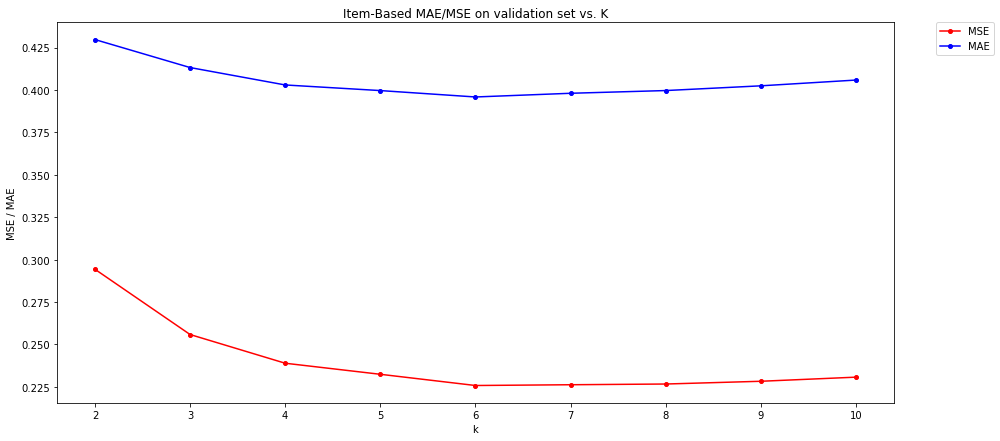

In [16]:
plt.figure(figsize=(15,7))
plt.title("Item-Based MAE/MSE on validation set vs. K")
plt.ylabel('MSE / MAE')
plt.xlabel('k');
plt.plot(range(2,11,1), np.asarray([error[k][0] for k in range(2,11,1)]), 'ro-', markersize=4, label="MSE")
plt.plot(range(2,11,1), np.asarray([error[k][1] for k in range(2,11,1)]), 'bo-', markersize=4, label="MAE")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

From the plot, we can see that the minimal error is for **K=6**.  
That means that, in oreder to get prediction with a minimal error, it is advised to use K=6.
Another observation from the result is that as value of K increases, we can get a lower MSE/MAE, which means a better prediction. However, the improvement plateaus at K=6.

### Item-Based KNN without bias

How can we improve our model?  
The prevous output is not bad, however, it is always good to implement additional optimizations.  
  
Now we will try removing biases associated with either the user or the item. The idea here is that certain users may tend to always give high or low ratings to all movies. We implemented our function above, and now we will use it on out test and train data.

In [13]:
# No bias
predicted_rating_list = {}
true_rating_list = {}
error_no_bias = {}

for k in range(2,11): # from 2 because 1 cannot give rating to itself
    predicted_rating_list = []
    true_rating_list = []
    for user_index in range(test.shape[0]):
        if test[user_index, :].nonzero()[0].size:
            for movie_index in test[user_index, :].nonzero()[0]:   
                similar_movies = top_k_movies(item_correlation, movie_by_index, movie_index, k)
                similar_movies_Indices = [movie.Index for movie in similar_movies] 
                similar_movies_Ratings = ratings_matrix[user_index, similar_movies_Indices]
                
                predicted_rating, true_rating = item_based_K_nearest_neighbours_without_bias(user_index, movie_index, k)
                #print(f"{predicted_rating} {true_rating}")
                predicted_rating_list.append(predicted_rating)
                true_rating_list.append(true_rating)
    
    MSE, MAE = calculate_error(true_rating_list, predicted_rating_list)
    error_no_bias[k] = MSE, MAE
    print(f"k: {k}")
    print(f'MSE = {MSE}, MAE = {MAE}')

k: 2
MSE = 0.2970176614083592, MAE = 0.4319505610668402
k: 3
MSE = 0.25348355925573246, MAE = 0.41050554742856543
k: 4
MSE = 0.23906969219453994, MAE = 0.40183836437977866
k: 5
MSE = 0.2337070468145442, MAE = 0.40022467537108936
k: 6
MSE = 0.22909322337531488, MAE = 0.39857136084007944
k: 7
MSE = 0.22713935926852424, MAE = 0.39860779303973476
k: 8
MSE = 0.22736248903753553, MAE = 0.4004197414226853
k: 9
MSE = 0.22821016708814687, MAE = 0.4021666533091471
k: 10
MSE = 0.2299430678752699, MAE = 0.4051272071215595


At this point, we cannot tell much. So, lets plot our result.

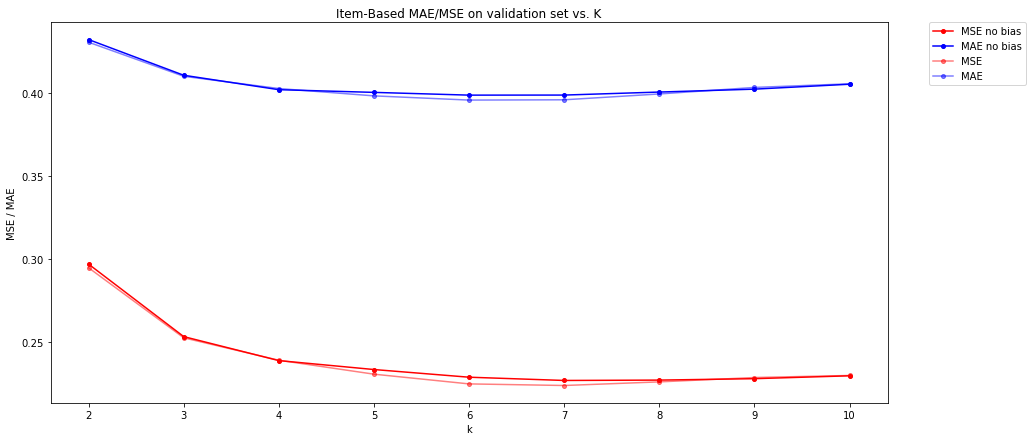

In [15]:
plt.figure(figsize=(15,7))
plt.title("Item-Based MAE/MSE on validation set vs. K")
plt.ylabel('MSE / MAE')
plt.xlabel('k');
plt.plot(range(2,11,1), np.asarray([error_no_bias[k][0] for k in range(2,11,1)]), 'ro-', markersize=4, label="MSE no bias")
plt.plot(range(2,11,1), np.asarray([error_no_bias[k][1] for k in range(2,11,1)]), 'bo-', markersize=4, label="MAE no bias")
plt.plot(range(2,11,1), np.asarray([error[k][0] for k in range(2,11,1)]), 'ro-', markersize=4, label="MSE", alpha=0.5)
plt.plot(range(2,11,1), np.asarray([error[k][1] for k in range(2,11,1)]), 'bo-', markersize=4, label="MAE", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

From the result it seems that the predictions without bias performe a little worse than with it. Or is it?  
While reading about the Pearson correlation, it seems that this algorithm takes into an account issues where popular movies are favourited so they tend to be in most of top K movies lists.